# Summary
Spendy is a newly launched buy now pay later product that has recently launched. 20000 were initially approved, with a 100% acceptance rate, to better understand customer behaviors and profitability of the product. The data on these customers have matured and the outcome has been recorded. Using this sample I have produced an approval and limits strategy that optimizes for profitability and have used this to assess a further sample of 10000 customers and forecast their profitability. I have also set a policy that could be used in the future to increase the profitability of future acquisitions.

## Key findings:
* A model was built to predict the probability of a customer defaulting, this model has a Gini of 0.32, implying reasonable discrimination
* Of the 10000 customers, it is expected 5.66% will default
* Based on the new policy 3764 of the 10000 customers should have been approved
* Accepting all 10000 customers is expected to generate a loss of c.-739000 Yen
* Applying the new limit policy to this sample is expected to generate a profit of c.517000 Yen

## Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Read in both data sets from excel
df = pd.read_excel('Risk and analytics credit risk analyst exercise.xlsx',sheet_name = 'Historical Data')
df2 = pd.read_excel('Risk and analytics credit risk analyst exercise.xlsx',sheet_name = 'New Data')

In [3]:
# Correct rename and remove redundant columns
cols = [col for col in df if not col.startswith('Unnamed:')]
print (cols)
paidy_hist_df = df[cols]
paidy_hist_df

['customer_id', 'amount', 'browser_type', 'has_points_card', 'high_risk_item', 'merchant_customer_age', 'item_category', 'purchase_time', 'age_range', 'flag_default']


,customer_id,amount,browser_type,has_points_card,high_risk_item,merchant_customer_age,item_category,purchase_time,age_range,flag_default
0,1,2849,computer,yes,NaN,2,fashion,12pm to 6pm,25-35,0
1,2,3699,computer,NaN,NaN,7,fashion,12pm to 6pm,15-25,0
2,3,2714,mobile,yes,NaN,0,electronics,12am to 6am,25-35,0
3,4,2980,mobile,yes,NaN,0,fashion,12pm to 6pm,35-45,1
4,5,1595,computer,yes,NaN,0,electronics,6pm to 12am,35-45,0
...,...,...,...,...,...,...,...,...,...,...
19995,19996,2754,other,yes,NaN,7,household,6am to 12pm,15-25,0
19996,19997,1902,computer,yes,NaN,5,fashion,12pm to 6pm,45-55,0
19997,19998,838,other,yes,NaN,0,fashion,12pm to 6pm,45-55,0
19998,19999,788,mobile,NaN,NaN,5,fashion,12pm to 6pm,15-25,1


In [4]:
# Get basic stats for numeric varibles
paidy_hist_df.describe()

,customer_id,amount,merchant_customer_age,flag_default
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,6583.724750,2.330950,0.056350
std,5773.647028,15185.723724,2.882575,0.230602
min,1.000000,1.000000,0.000000,0.000000
25%,5000.750000,1316.000000,0.000000,0.000000
50%,10000.500000,2632.500000,0.000000,0.000000
75%,15000.250000,5399.000000,5.000000,0.000000
max,20000.000000,282424.000000,7.000000,1.000000


In [5]:
paidy_hist_df.nunique()

customer_id              20000
amount                    6920
browser_type                 3
has_points_card              1
high_risk_item               1
merchant_customer_age        8
item_category                4
purchase_time                4
age_range                    5
flag_default                 2
dtype: int64

In [6]:
paidy_hist_df.isna().sum()

customer_id                  0
amount                       0
browser_type                 0
has_points_card           2023
high_risk_item           19748
merchant_customer_age        0
item_category                0
purchase_time                0
age_range                    0
flag_default                 0
dtype: int64

In [7]:
# Replace nan values and recode varible as binarys 
paidy_hist_df['has_points_card'] = np.where(paidy_hist_df['has_points_card']=='yes',1,0)
paidy_hist_df['high_risk_item'] = np.where(paidy_hist_df['high_risk_item']=='yes',1,0)

paidy_hist_df

,customer_id,amount,browser_type,has_points_card,high_risk_item,merchant_customer_age,item_category,purchase_time,age_range,flag_default
0,1,2849,computer,1,0,2,fashion,12pm to 6pm,25-35,0
1,2,3699,computer,0,0,7,fashion,12pm to 6pm,15-25,0
2,3,2714,mobile,1,0,0,electronics,12am to 6am,25-35,0
3,4,2980,mobile,1,0,0,fashion,12pm to 6pm,35-45,1
4,5,1595,computer,1,0,0,electronics,6pm to 12am,35-45,0
...,...,...,...,...,...,...,...,...,...,...
19995,19996,2754,other,1,0,7,household,6am to 12pm,15-25,0
19996,19997,1902,computer,1,0,5,fashion,12pm to 6pm,45-55,0
19997,19998,838,other,1,0,0,fashion,12pm to 6pm,45-55,0
19998,19999,788,mobile,0,0,5,fashion,12pm to 6pm,15-25,1


In [8]:
# Investigate catagorical data
def histo_def_rate(dset,var,graph = True,label = True):
    #Calculate the nuber of records in each group
    vol = dset.groupby(var).count()['flag_default'].reset_index().rename({'flag_default':'vol'},axis='columns')
    #Calculate the number of default in each group
    sum_def = dset.groupby(var).sum()['flag_default'].reset_index().rename({'flag_default':('flag_default_sum')},axis='columns')
    #Get data togetehr to calculate default rates
    out = pd.merge(vol,sum_def,how='left',on=var)
    out['def_rate'] = out['flag_default_sum']/out['vol']
    #Plot the resultant information
    if graph == True:
            fig, axes = plt.subplots(1, 3, figsize=(20,5))
            fig.suptitle(var,fontsize=16)
            for col, axis in zip(['vol','flag_default_sum','def_rate'],axes.flatten()):
                axis.bar(out[var],out[col])
                axis.set_title(col)
                if label == True:
                    for p in axis.patches:
                        if (p.get_height()%1 != 0):
                            height = ('{:.3f}'.format(p.get_height()))
                        else:
                            height = p.get_height()
                        axis.annotate(height, (p.get_x()+0.25, p.get_height()/2))
            plt.show()
    if graph == False:
        return out

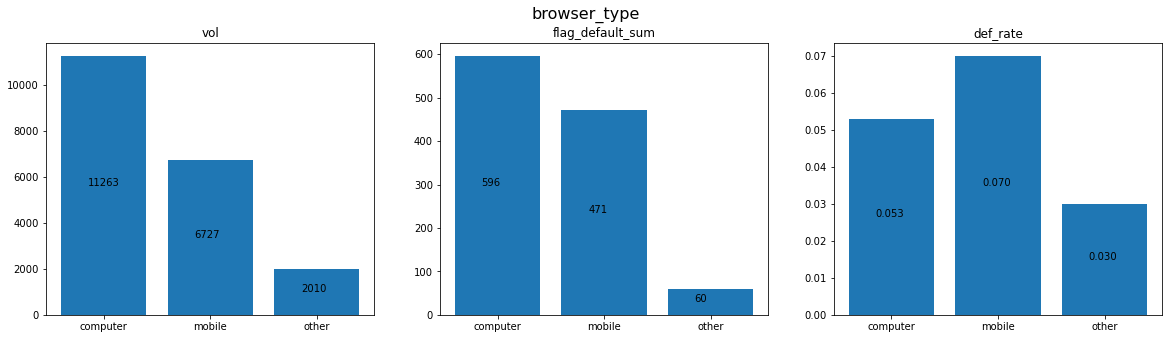

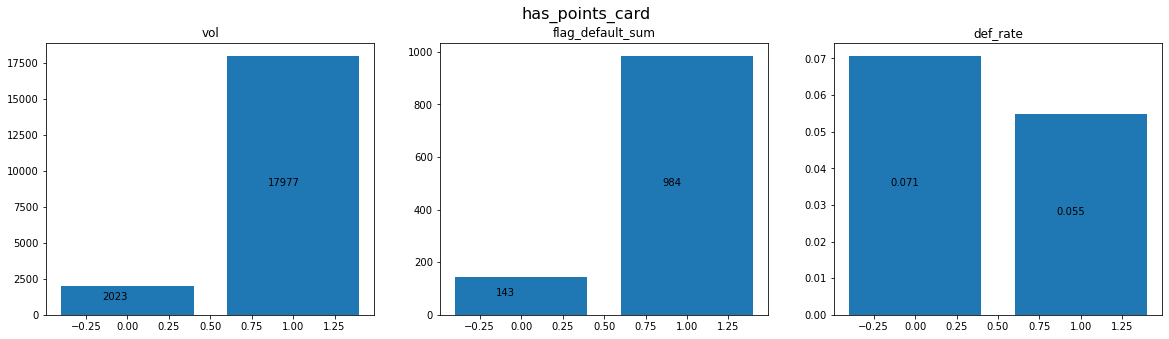

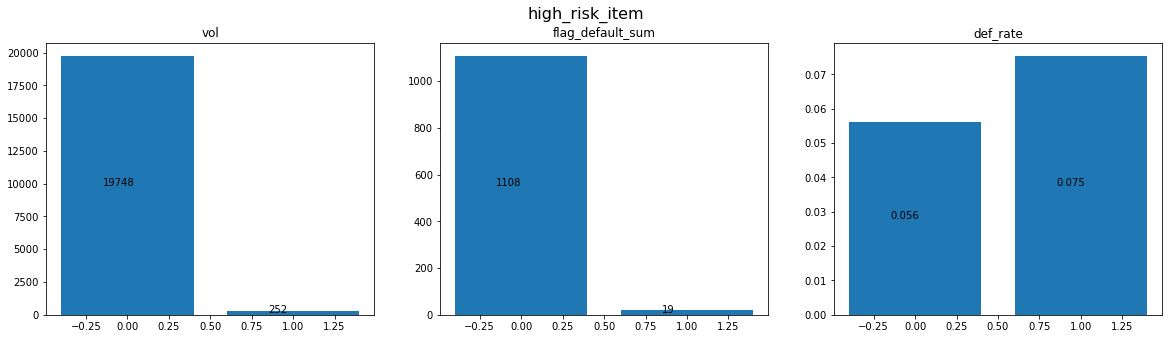

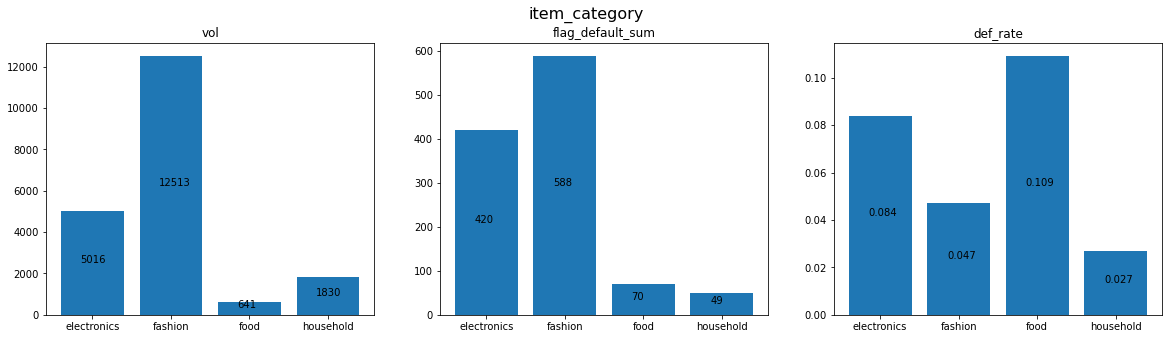

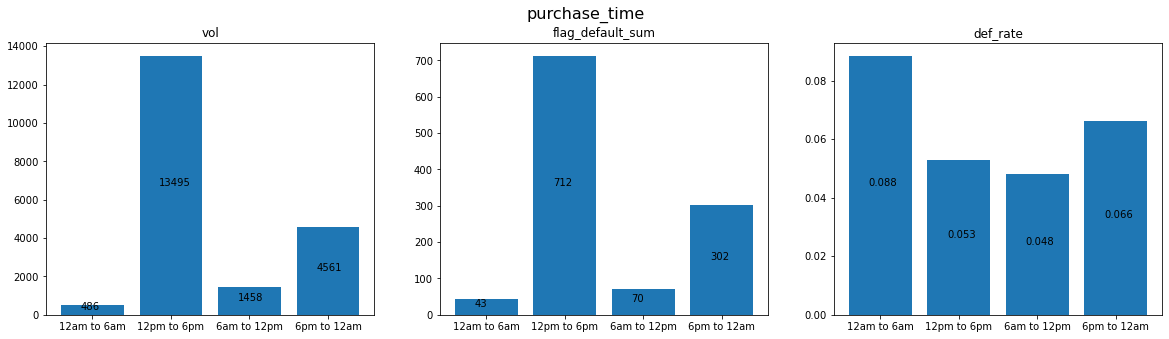

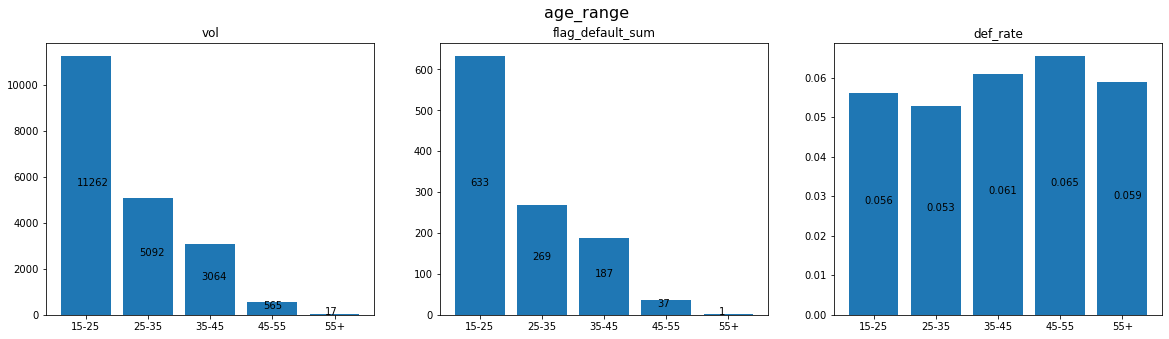

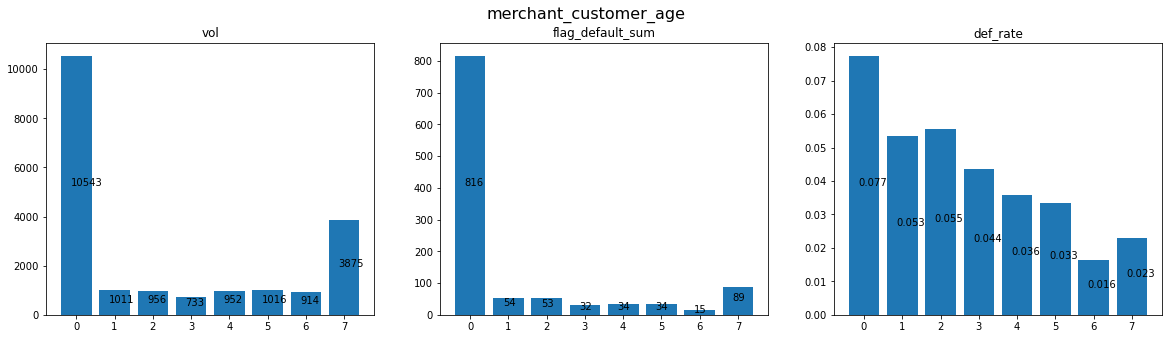

In [9]:
plot_types = {'catagory': ['browser_type',
                             'has_points_card',
                             'high_risk_item',
                             'item_category',
                             'purchase_time',
                             'age_range',
#                              'flag_default',
                             'merchant_customer_age'],
              'numeric': 'amount'   
}
for cat in plot_types['catagory']:
    histo_def_rate(paidy_hist_df,cat,graph=True)

We can see there is some discrimination in default rates between some of the categories in the data. This implies that a model to determine PD can be built. This is useful as we would like to try and avoid using the amount variable in the PD model, to avoid a feedback loop when we set the limit of amount based, partially, on the PD. 

In [10]:
#Look at how amount is distributed across its range
desc = paidy_hist_df['amount'].describe().to_dict()
desc

{'count': 20000.0,
 'mean': 6583.72475,
 'std': 15185.723723828476,
 'min': 1.0,
 '25%': 1316.0,
 '50%': 2632.5,
 '75%': 5399.0,
 'max': 282424.0}

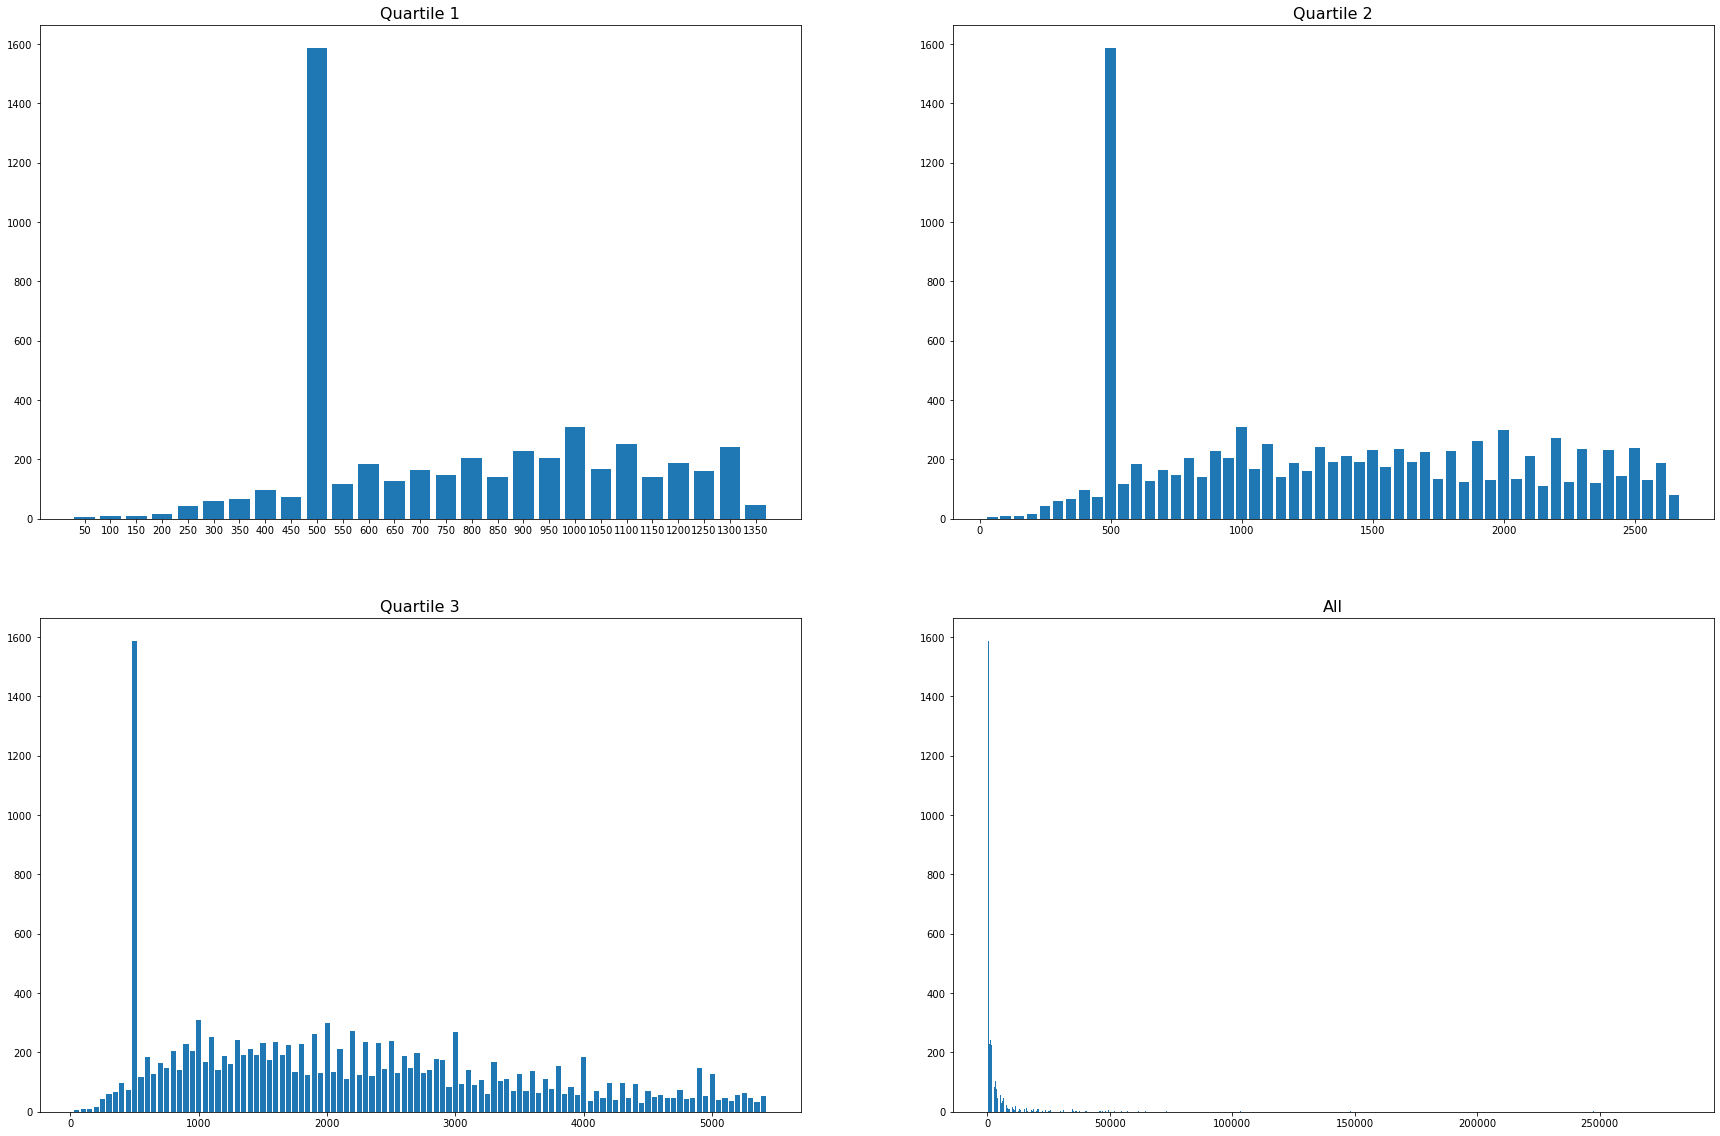

In [11]:
# Since we have a large range and st.dev its is more useful to look at this varible in quartiles

#Set up bins for continuse varible 
paidy_hist_df['amount_bin'] = paidy_hist_df['amount'].apply(lambda x: (math.ceil(x/50)*50))

#Plot quartile plots
quart1 = paidy_hist_df[paidy_hist_df['amount'] <= desc['25%']].copy()
quart2 = paidy_hist_df[paidy_hist_df['amount'] <= desc['50%']].copy()
quart3 = paidy_hist_df[paidy_hist_df['amount'] <= desc['75%']].copy()

#Set up plot grid
fig, axes = plt.subplots(2, 2, figsize=(30,20))

vols = histo_def_rate(quart1,'amount_bin',graph=False,label=False)
axes[0,0].bar(vols['amount_bin'],vols['vol'],width=40,tick_label=vols['amount_bin'])
axes[0,0].set_title('Quartile 1',fontsize=16)

vols = histo_def_rate(quart2,'amount_bin',graph=False,label=False)
axes[0,1].bar(vols['amount_bin'],vols['vol'],width=40)
axes[0,1].set_title('Quartile 2',fontsize=16)

vols = histo_def_rate(quart3,'amount_bin',graph=False,label=False)
axes[1,0].bar(vols['amount_bin'],vols['vol'],width=40)
axes[1,0].set_title('Quartile 3',fontsize=16)

vols = histo_def_rate(paidy_hist_df,'amount_bin',graph=False,label=False)
axes[1,1].bar(vols['amount_bin'],vols['vol'],width=40)
axes[1,1].set_title('All',fontsize=16)

plt.show()



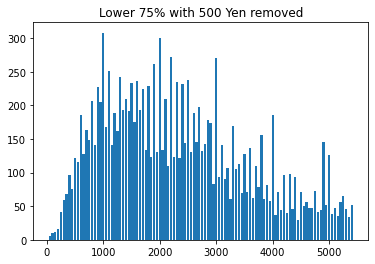

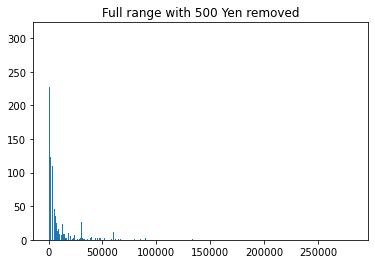

In [12]:
# remove the spike at 500 to better look at shape of data 
vols = histo_def_rate((paidy_hist_df[(paidy_hist_df['amount'] != 500)&(paidy_hist_df['amount'] <= desc['75%'])]),'amount_bin',graph=False,label=False)
plt.bar(vols['amount_bin'],vols['vol'],width=40)
plt.title('Lower 75% with 500 Yen removed')
plt.show()

# remove 500 spike
vols = histo_def_rate((paidy_hist_df[(paidy_hist_df['amount'] != 500)]),'amount_bin',graph=False,label=False)
plt.bar(vols['amount_bin'],vols['vol'],width=40)
plt.title('Full range with 500 Yen removed')
plt.show()

We can see that despite the amount variable having a very wide range it is heavily skewed to the lower end of the spectrum. This is useful to know when considering the variance in profitability.

## Comparing the historic data from to the New data

Since we are looking to use this historic data to develop a strategy that can be applied to the new portfolio of customers we need to make sure that these populations are broadly the same. The population can change for several reasons,  changes in the broader economy or acquisition strategy, even marketing can have an affect. If these populations are not broadly similar we may need to carry out some stratification, 

By plotting the categories side by side we can make a visual inspection to see if there is any obvious drift. If there is an issue we can use a population stability statistic to make a more detailed assessment of differences.

In [13]:
# # Carry out the same pre processing to remove nan values
# # only run this once or you will overwrite the whole column with 0 values
# df2['has_points_card'] = np.where(df2['has_points_card']=='yes',1,0)
# df2['high_risk_item'] = np.where(df2['high_risk_item']=='yes',1,0)

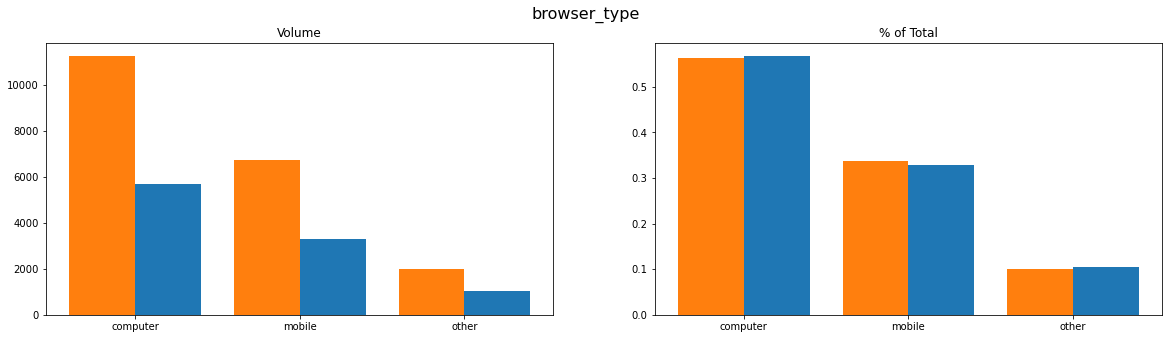

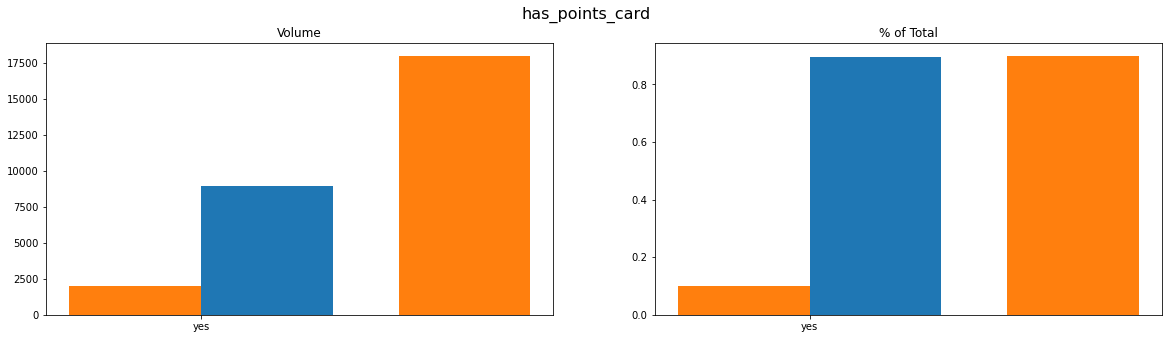

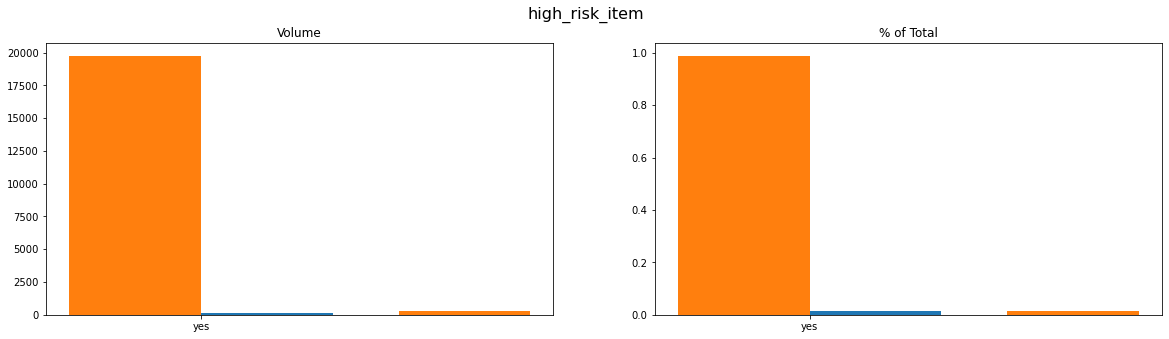

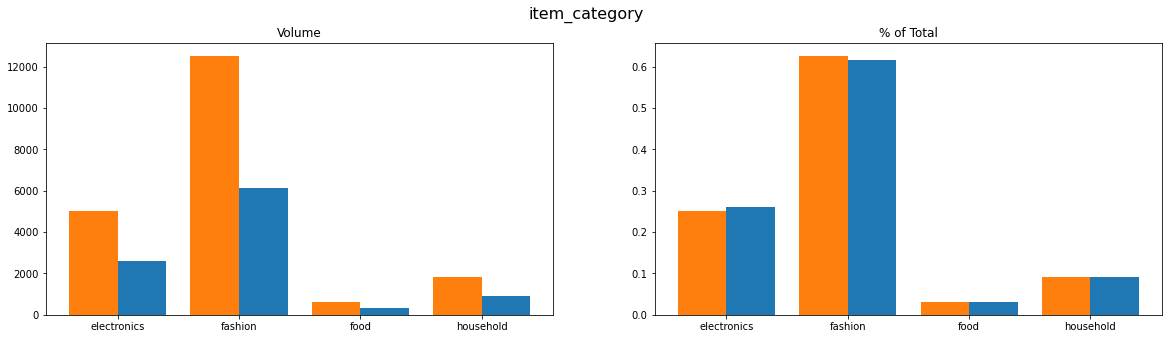

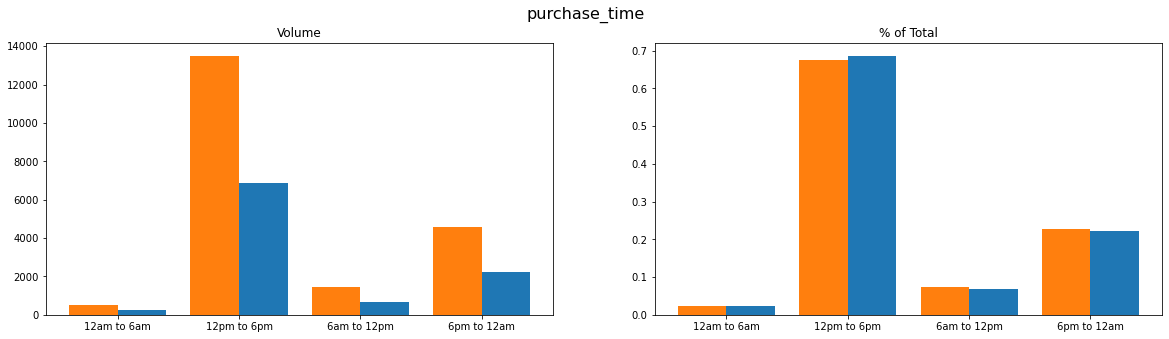

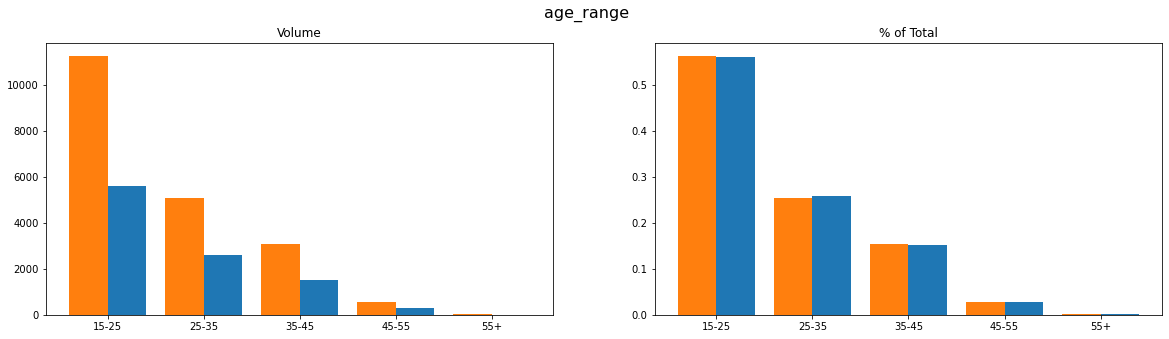

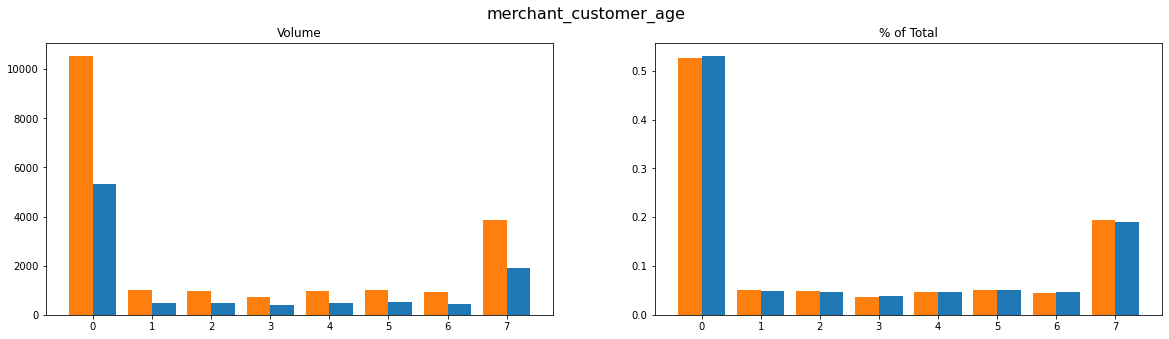

In [14]:

# Plot the categories from each dataset next to each other on the same plot
def new_data_hist(dset,dset2,var,w):
    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle(var,fontsize=16)
    
    vol = dset.groupby(var).count()['customer_id'].reset_index().rename({'customer_id':'vol'},axis='columns')
    vol2 = dset2.groupby(var).count()['customer_id'].reset_index().rename({'customer_id':'vol'},axis='columns')  
    
    axes[0].bar(vol[var],vol['vol'],width=w,align='edge')
    axes[0].bar(vol2[var],vol2['vol'],width=-w,align='edge')
    axes[0].set_title('Volume')
    
    vol['pct_total'] = vol['vol']/dset.count()['customer_id']
    vol2['pct_total'] = vol2['vol']/dset2.count()['customer_id']
    
    axes[1].bar(vol[var],vol['pct_total'],width=w,align='edge')
    axes[1].bar(vol2[var],vol2['pct_total'],width=-w,align='edge')
    
    axes[1].set_title('% of Total')
    
    
    plt.show()
    return
    

for cat in plot_types['catagory']:
    new_data_hist(df2,paidy_hist_df,cat,0.4)
    

We can see that on a proportional basis there is little difference between the historic and new data sets categorical variables. MEaning we can apply any model developed on the historic data to the new data with a high degree on confidence that the perfomace should be similar.

In [15]:
desc = df2['amount'].describe().to_dict()
desc

{'count': 10000.0,
 'mean': 6591.6151,
 'std': 15660.16854777897,
 'min': 23.0,
 '25%': 1311.0,
 '50%': 2635.5,
 '75%': 5445.0,
 'max': 288484.0}

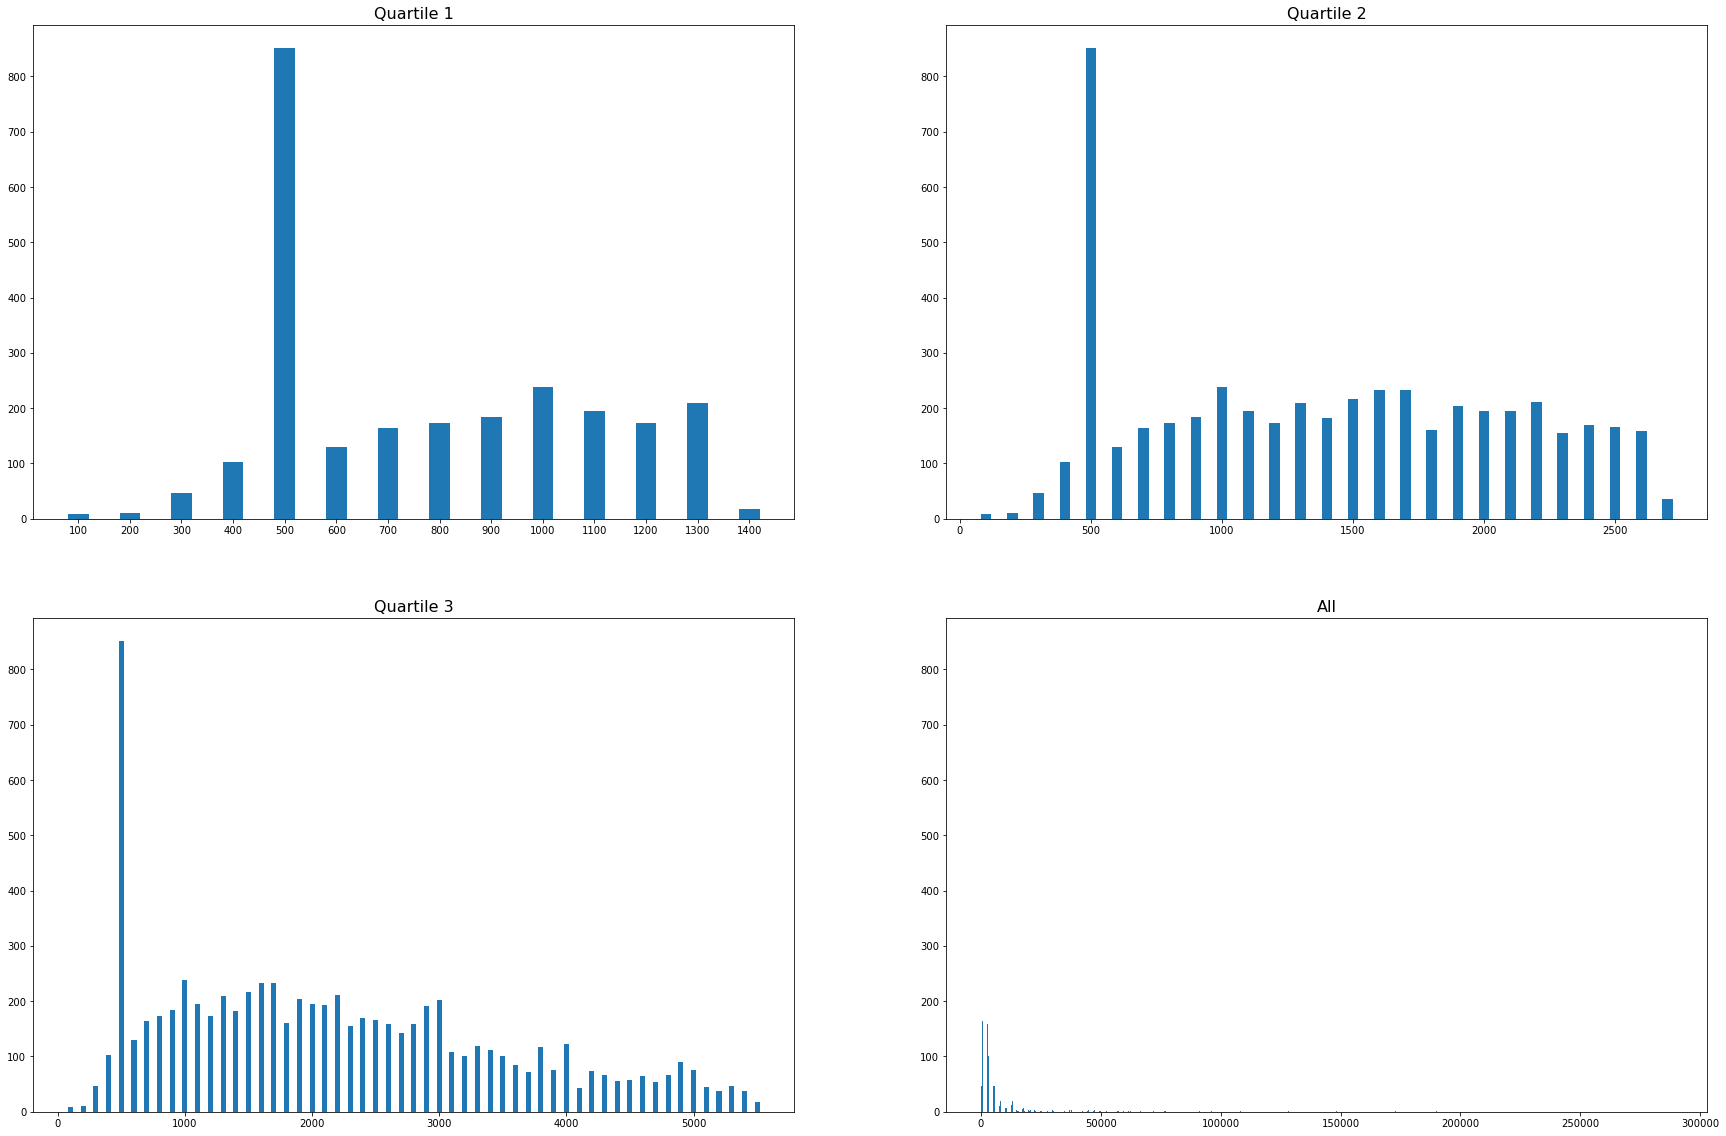

In [16]:
#Set up bin for continuous varible
df2['amount_bin'] = df2['amount'].apply(lambda x: (math.ceil(x/100)*100))
quart1 = df2[df2['amount'] <= desc['25%']].copy()
quart2 = df2[df2['amount'] <= desc['50%']].copy()
quart3 = df2[df2['amount'] <= desc['75%']].copy()


fig, axes = plt.subplots(2, 2, figsize=(30,20))

vols = quart1.groupby('amount_bin').count()['customer_id'].reset_index().rename({'customer_id':'vol'},axis='columns')
axes[0,0].bar(vols['amount_bin'],vols['vol'],width=40,tick_label=vols['amount_bin'])
axes[0,0].set_title('Quartile 1',fontsize=16)

vols = quart2.groupby('amount_bin').count()['customer_id'].reset_index().rename({'customer_id':'vol'},axis='columns')
axes[0,1].bar(vols['amount_bin'],vols['vol'],width=40)
axes[0,1].set_title('Quartile 2',fontsize=16)

vols = quart3.groupby('amount_bin').count()['customer_id'].reset_index().rename({'customer_id':'vol'},axis='columns')
axes[1,0].bar(vols['amount_bin'],vols['vol'],width=40)
axes[1,0].set_title('Quartile 3',fontsize=16)

vols = df2.groupby('amount_bin').count()['customer_id'].reset_index().rename({'customer_id':'vol'},axis='columns')
axes[1,1].bar(vols['amount_bin'],vols['vol'],width=40)
axes[1,1].set_title('All',fontsize=16)

plt.show()

Visually comparing the distribution of value across the range for the amount we can see that this too is very similar. There is a similar spike at 500 yen and the skew is broadly in the same range. This is in line with expectation as there was no change in strategy reported between the acquisition of the two populations.

# Feature pre-processing
As we have several categorical variables these need to be reformatted to make them more compatible with some algorithms. For this, we can set dummy variables for each category of each of the variables. 


In [17]:
# #One hot encoding
paidy_hist_df = pd.get_dummies(paidy_hist_df, columns=['browser_type','item_category','purchase_time','merchant_customer_age','age_range'])
paidy_hist_df

,customer_id,amount,has_points_card,high_risk_item,flag_default,amount_bin,browser_type_computer,browser_type_mobile,browser_type_other,item_category_electronics,...,merchant_customer_age_3,merchant_customer_age_4,merchant_customer_age_5,merchant_customer_age_6,merchant_customer_age_7,age_range_15-25,age_range_25-35,age_range_35-45,age_range_45-55,age_range_55+
0,1,2849,1,0,0,2850,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,3699,0,0,0,3700,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,3,2714,1,0,0,2750,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3,4,2980,1,0,1,3000,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,1595,1,0,0,1600,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,2754,1,0,0,2800,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
19996,19997,1902,1,0,0,1950,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
19997,19998,838,1,0,0,850,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
19998,19999,788,0,0,1,800,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


## Build a PD Model

To assess profitability, one of the components we need to estimate is the expected credit loss (CL). This is made up of 3 components:
 1. Probability of default (PD) - how likely is it a customer will not repay the borrowed amount
 2. Exposure at default (EAD) - how much did the customer still owe us when they defaulted
 3. Loss given default (LGD) - how much of the debt cannot be recovered

These 3 components are generally given as percentages that are multiplied together along with the borrowed amount to give the expected credit loss.

From the brief, we can say that the EAD is 97.5% of the amount borrowed as this is the amount that leaves spendy when a customer makes a purchase using the product. (Making this assumption will mean the remaining 2.5% has to be accounted for elsewhere but we will get to that.) 

The LGD is assumed to be 100% as the product is unsecured is no indication of post-default recoveries from the information available.

### Choice of inputs
PD is the major differentiating factor in credit loss and as a result profitability between customers. We need to try and keep this PD estimation independent from the amount borrowed as we are going to be limiting the amount borrowed. These limits would change the “through the door” population of a portfolio and reduce the reliability of the estimates when they are applied to the new population, possibly leading to the need for recalibration, which would change the limit, which changes the population….. This is the feedback loop mentioned earlier.

By assuming that PD is independent of the amount borrowed we can avoid this situation, simplifying the limit setting process. In practice, there are normally more impactful things on the profitability of a product than this assumption that could be tackled first before the benefits outweigh the increase in complexity of modeling.  (limited data for example)

### Choice of algorithm
This leaves us with the need to calculate the PD value for each customer, this can be done with a classification algorithm as we have labeled defaults in the historic data provided. 
The algorithm chosen to train our PD model was a gradient boosting classafier, this is an ensemble method that builds successive decision trees based on the miss classification of previous trees. This process is repeated until no further reduction in error is possible. These weak trees are then combined in a additive fashion to calculate a probability of an observation belonging to a given class.

This algorithm was choosen after some expermentaion with different algorithms and due to its resistance to over fitting allowing to better stability when applied to other no training data. 

### Cross validation

In order to increase the models resistance to over fitting of the training sample cross validation was used when training the model. This was done by taking the historic data and randomly splitting the sample into a training and test set at a ratio of 75% : 25%. These splits were staratfied meaning the proportion of categories etc were preserved. A model was then trained on the 75% training sample and then scored on the 25% sample and the relevant performance metrics were calculated. This process was carried out 5 times and the average performance metric is taken as the performance of the data. 

 **NB The purpose of the cross validation was not to tune hyper parameters as no holdout sample was used, however there was some tuning carried out.**
 

In [18]:
# Only use varibles that will be know at the point a decsison is being made.
# Do not incluse the amount varible to maintain independence of amount and PD estimate
not_at_decison = ['customer_id',
                  'amount',
                  'flag_default',
                  'amount_bin',
                  'payment_fee',
                  'age_range',
                  'merchant_customer_age',
                  'convenience_store_fee',
                  'collection_fee',
                  'credit_loss',
                  'profit']

inputs = [x for x in paidy_hist_df.columns.to_list() if x not in not_at_decison]

X = paidy_hist_df[inputs]

#flag_default is the target we are looking to classify (how likely is the customer to default given the inputs)
y = paidy_hist_df['flag_default']

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

name='Gradient Boosting Model'

scoring = {'AUC': 'roc_auc', 'F1_Score':'f1', 'Recall':'recall'}

#Set up cross validation to increase the robustness of the model to changes in population
#Using the F1 score to achive a blance between coverage of predictions and the acuracy of thos rediction. This is due to default being rare event casuing imbalanced data
gs = GridSearchCV(GradientBoostingClassifier(random_state=123,learning_rate = 0.1,n_estimators=100,max_depth=1),
                                             param_grid={
                                                          'min_samples_leaf':range(10, 20, 10), \
                                                         }
                                             ,scoring=scoring, refit='AUC', return_train_score=True)
                  
gs.fit(X,y)
results = gs.cv_results_
# results
clf = gs.best_estimator_

###  Evaluate the model performace

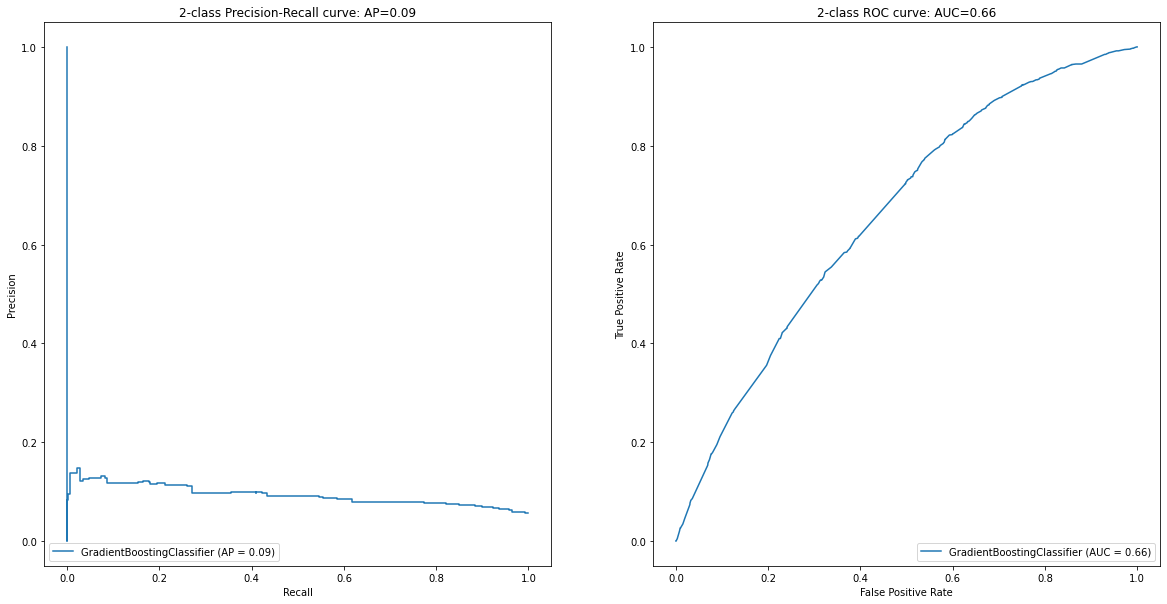

Gradient Boosting Model
Gradient Boosting Model: Actual 1127 vs Expected 1127.1269581694316
Difference: -0.12695816943164573
Accuracy: 0.94365
Gini on Training data: 0.32


In [20]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

#score up data using the trained model
y_score = clf.predict_proba(X)[:,1]

#Plot PR and ROC curve to show discrimition performance
fig, axes = plt.subplots(1, 2, figsize=(20,10))

average_precision = average_precision_score(y, y_score)

disp = plot_precision_recall_curve(clf, X, y, ax=axes[0])

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

disp = plot_roc_curve(clf, X, y, ax=axes[1])
disp.ax_.set_title('2-class ROC curve: '
                   'AUC={0:0.2f}'.format(disp.roc_auc))

trained_gini = (2 * disp.roc_auc) - 1




plt.show()

#Calculate some performance metrics metrics
print('{}'.format(name))
print('{}: Actual {} vs Expected {}'.format(name,y.sum(), y_score.sum()))
print('Difference: {}'.format((y.sum()-y_score.sum())))
print('Accuracy: {}'.format(clf.score(X,y)))
print('Gini on Training data: {0:0.2f}'.format(trained_gini))


We can see that for the population sample we are getting a very close match between the actual number of defaults and the expected number of default across the portfolio. 
However, the high accuracy score is deceiving as this is non-default rate. Basically saying if we predict no account will default we will be correct 94% of the time. This is why the Gini score is a better metric to evaluate this. A Gini score of 0 represents the average discrimination between default and non-defaults of random guessing, so a score of 0.32 indicates above-average discrimination. Based on experimentation and some exploratory workout with this notebook (see the rough version) this is a relatively good model given the data provided.

In [21]:
# Add PD column to data set
paidy_hist_df['pd'] = clf.predict_proba(paidy_hist_df[inputs])[:,1]
paidy_hist_df
#Check it has been applied correctly
paidy_hist_df['flag_default'].sum() , paidy_hist_df['pd'].sum()

(1127, 1127.1269581694316)

# Calculating Profitability of Customers

From the brief there are 4 profit drivers:
Payment facilitation fee - An income based on 2.5% of the purchase amount
Repayment Fee - paid by customers who make their repayment from a convenience store
Collection cost - incurred by calling the customer in the case of a default
Credit loss - incurred when a customer doesn’t pay back the borrowed amount

From this we can construct a profitability equation:
Profit = PF + RF - CC - CL

**NB This calculation is based on a single translation in the real world it would be wise to assess a customer lifetime value instead of a single transaction.
This calculation very simplified and is excluding some factor what would normally be in profitability calculation. For example it is assuming that all funds are being drawn from Spendys own capital and not borrowed, therefore there is no funding cost included.**

However each of these components can be broken down further to better understand them.

The Payment facilitation fee is only recived when a customer makes their payment and clears balance by paying back the borrowed amount. This means that the PF is based on their PD given by the following

PF = (1-PD) * 2.5% * Amount

### Repayment Fee

The repayment fee is a 200 Yen fee that is paid to Spendy when the customer make a payment via a convenience store. From the brief  we know that 80% of customers who made a patent did so via this channel. Ths allow us to constra uct:

RF = (1-PD) * 0.8 * 200

**NB This can be updated if we can get more granular data on the demographics that are making payments by the convenience store channel.**

### Collection Cost

The collection cost is the cost of a phone call made to customers who have not made there payment. This means the expected collection cost scales with PD.

CC = PD * 300

**NB It would be good to better understand what impact this intervention has on the recovery of funds after default. This would allow for better estimates of LGD and assess if this cost is worthwhile.**

### Credit Loss
As discussed above the credit loss is the amount we expect to lose for each customer due to there inabailty to pay back the amount borrowed. This is represented by a set of factors multipided by the amount borrowed. 

CL = PD * EAD * LGD * Amount

With these definition in mind we can calculate both the expcted and actual porfit for each customer. For expected profit the PD is the estimate from the model above and for the actual profit we cans use the observed defaults as the PD.

In [22]:
# Add PD column to data set
paidy_hist_df['pd'] = clf.predict_proba(paidy_hist_df[inputs])[:,1]
paidy_hist_df

def calculate_profit(df,pd,profit_type
                     ,payment_fee_rate = 0.025
                     ,convenience_store_fee = 200
                     ,convenience_store_pay_pct = 0.8
                     ,collection_fee = 300
                     ,EAD_coeff = 0.975
                     ,LGD_coeff = 1
                     ,balance = 'amount'
                    ):

    # Calculate fees
    #Payment fee = proabaility of paying* amount* fee rate
    payment_fee_col = '{}payment_fee'.format(profit_type)
    payment_fee_factor_col = '{}pay_fee_factor'.format(profit_type)
    df[payment_fee_factor_col] = (1-df[pd]) * payment_fee_rate
    df[payment_fee_col] = df[payment_fee_factor_col] * df[balance]

    # Conveni fee income
    # fee = proabaility of paying * chance you pay at conveni * convine fee
    convenience_store_fee_col = '{}convenience_store_fee'.format(profit_type)
    df[convenience_store_fee_col] = (1-df[pd]) * convenience_store_fee * convenience_store_pay_pct


    #collection cost
    # fee = probability of default * collection fee 
    collection_fee_col = '{}collection_fee'.format(profit_type)
    df[collection_fee_col] = df[pd] * collection_fee

    #Credit loss
    # EAD is the money that actually leave spendy on sale
    # amount * EAD
    ead_col = '{}EAD'.format(profit_type)
    df[ead_col] = EAD_coeff  # this is the money that actualy leave spendy, contracy to email but just a namin convention

    # LGD if the portion that is unrecoverable
    lgd_col = '{}LGD'.format(profit_type)
    df[lgd_col] = LGD_coeff # no recovery infomation provided assume everything is lost

    #Credit loss factor = probability of default * exposure at default * loss given default
    credit_loss_factor_col = '{}CLF'.format(profit_type)
    df[credit_loss_factor_col] = df[pd] * df[ead_col] * df[lgd_col]
    
    #Credit loss = Credit loss Factor * balance
    credit_loss_col = '{}credit_loss'.format(profit_type)
    df[credit_loss_col] = df[credit_loss_factor_col] * df[balance]

    #profit = income from payment fee + income from convinece store payments - cost of collection activity - credit loss
    profit_col = '{}profit'.format(profit_type)
    df[profit_col] = df[payment_fee_col] + df[convenience_store_fee_col] - df[collection_fee_col] - df[credit_loss_col]
    return

calculate_profit(paidy_hist_df,'pd','expected_')
calculate_profit(paidy_hist_df,'flag_default','actual_')

paidy_hist_df

,customer_id,amount,has_points_card,high_risk_item,flag_default,amount_bin,browser_type_computer,browser_type_mobile,browser_type_other,item_category_electronics,...,expected_profit,actual_pay_fee_factor,actual_payment_fee,actual_convenience_store_fee,actual_collection_fee,actual_EAD,actual_LGD,actual_CLF,actual_credit_loss,actual_profit
0,1,2849,1,0,0,2850,1,0,0,0,...,112.169461,0.025,71.225,160.0,0,0.975,1,0.000,0.0,231.225
1,2,3699,0,0,0,3700,1,0,0,0,...,140.344578,0.025,92.475,160.0,0,0.975,1,0.000,0.0,252.475
2,3,2714,1,0,0,2750,0,1,0,1,...,-185.256739,0.025,67.850,160.0,0,0.975,1,0.000,0.0,227.850
3,4,2980,1,0,1,3000,0,1,0,0,...,-11.891852,0.000,0.000,0.0,300,0.975,1,0.975,2905.5,-3205.500
4,5,1595,1,0,0,1600,1,0,0,1,...,12.478118,0.025,39.875,160.0,0,0.975,1,0.000,0.0,199.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,2754,1,0,0,2800,0,0,1,0,...,171.439382,0.025,68.850,160.0,0,0.975,1,0.000,0.0,228.850
19996,19997,1902,1,0,0,1950,1,0,0,0,...,124.812660,0.025,47.550,160.0,0,0.975,1,0.000,0.0,207.550
19997,19998,838,1,0,0,850,0,0,1,0,...,116.839373,0.025,20.950,160.0,0,0.975,1,0.000,0.0,180.950
19998,19999,788,0,0,1,800,0,1,0,0,...,118.076506,0.000,0.000,0.0,300,0.975,1,0.975,768.3,-1068.300


In [23]:
total_profit = paidy_hist_df['actual_profit'].sum()
mean_profit = paidy_hist_df['actual_profit'].mean()
print('Actual Profit of the Historic Data')
print('Total Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Profit: {0:0.0f} Yen'.format(mean_profit))

Actual Profit of the Historic Data
Total Profit: -11485030 Yen
Mean Profit: -574 Yen


In [24]:
total_profit = paidy_hist_df['expected_profit'].sum()
mean_profit = paidy_hist_df['expected_profit'].mean()
print('Expected Profit of the Historic Data')
print('Total Expected Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Expected Profit: {0:0.0f} Yen'.format(mean_profit))

Expected Profit of the Historic Data
Total Expected Profit: -1539088 Yen
Mean Expected Profit: -77 Yen


Based on our profitability calculation we can see we are losing money on the historic customer, this is to be expected due to the 100% approval rate. 

We can also see that our actual losses are much higher than the expected losses. This is because not all defaults are equal, and losses of large amounts defaulting will out weigh the profit from lower value non defaulters. 

This is a draw back of keeping the PD independent of amount borrowed, even though they are likely correlated due to things like fraud and credit abuse. (If you are going to default it might as well be for the most amount possible.) 

However by applying a policy we can look to reduce the difference between the actual and expected profit.  

# Policy: Don't lend to customers who are expected to lose Spendy money.


In [25]:
paidy_hist_df['Decison'] = np.where(paidy_hist_df['expected_profit'] >= 0,'Accept','Decline')
paidy_hist_df

,customer_id,amount,has_points_card,high_risk_item,flag_default,amount_bin,browser_type_computer,browser_type_mobile,browser_type_other,item_category_electronics,...,actual_pay_fee_factor,actual_payment_fee,actual_convenience_store_fee,actual_collection_fee,actual_EAD,actual_LGD,actual_CLF,actual_credit_loss,actual_profit,Decison
0,1,2849,1,0,0,2850,1,0,0,0,...,0.025,71.225,160.0,0,0.975,1,0.000,0.0,231.225,Accept
1,2,3699,0,0,0,3700,1,0,0,0,...,0.025,92.475,160.0,0,0.975,1,0.000,0.0,252.475,Accept
2,3,2714,1,0,0,2750,0,1,0,1,...,0.025,67.850,160.0,0,0.975,1,0.000,0.0,227.850,Decline
3,4,2980,1,0,1,3000,0,1,0,0,...,0.000,0.000,0.0,300,0.975,1,0.975,2905.5,-3205.500,Decline
4,5,1595,1,0,0,1600,1,0,0,1,...,0.025,39.875,160.0,0,0.975,1,0.000,0.0,199.875,Accept
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,2754,1,0,0,2800,0,0,1,0,...,0.025,68.850,160.0,0,0.975,1,0.000,0.0,228.850,Accept
19996,19997,1902,1,0,0,1950,1,0,0,0,...,0.025,47.550,160.0,0,0.975,1,0.000,0.0,207.550,Accept
19997,19998,838,1,0,0,850,0,0,1,0,...,0.025,20.950,160.0,0,0.975,1,0.000,0.0,180.950,Accept
19998,19999,788,0,0,1,800,0,1,0,0,...,0.000,0.000,0.0,300,0.975,1,0.975,768.3,-1068.300,Accept


In [26]:
print('Accept Rate')
paidy_hist_df['Decison'].value_counts()

Accept Rate


Accept     13803
Decline     6197
Name: Decison, dtype: int64

In [27]:
total_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['actual_profit'].sum()
mean_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['actual_profit'].mean()
print('Actual Profit of the Historic Data')
print('Total Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Profit: {0:0.0f} Yen'.format(mean_profit))

Actual Profit of the Historic Data
Total Profit: 1223477 Yen
Mean Profit: 89 Yen


In [28]:
total_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['expected_profit'].sum()
mean_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['expected_profit'].mean()
print('Expected Profit of the Historic Data')
print('Total Expected Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Expected Profit: {0:0.0f} Yen'.format(mean_profit))

Expected Profit of the Historic Data
Total Expected Profit: 1415994 Yen
Mean Expected Profit: 103 Yen


In [29]:
stdev = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['expected_profit'].std()
print('Expected Profit of the Historic Data')
print('Mean Expected Profit: {0:0.0f} Yen'.format(mean_profit))
print('Standard deviation of Profit: {0:0.0f} Yen'.format(stdev))

Expected Profit of the Historic Data
Mean Expected Profit: 103 Yen
Standard deviation of Profit: 51 Yen


Now we can see that by declining roughly c.30% of the previously accepted customer, all of whom we expect to loss us money. The actual and expected profitability are much more closely aligned but are not exactly the same. This is partially due to the uncertanty in the PD estimates. However we can account for this by building in some buffer into who we accept and who we decline. In policy 1 we chose to accept anyone who would not result in a loss, instead we should be accepting people who are going to turn a profit above an given level. This can be done by setting credit limits and not lending beyond these limits.

## What should this buffer be? 

For each customer the expected profit estimate we make is based on the mean of all customers that express those same characteristic. We know that the true average profit will deviate from this value by some amount. (Again this is due to the linear relationship between PD and profitability). So some customers will be expected to make more than this value some will be making less. So we are in effect making a loss on 50% of customer we expect to make 0 profit, so we need to shift our minimum threshold to account for as many of these loss making accounts as possible. If we were to shift the buffer to be twice the standard deviation, we can exclude c.95% of these loss maing account at the margin.

Therefore our buffer should be set to c.100 Yen

**NB This is assuming the profitability is normally distibuted. We can see this is not the case given profit is a relatively linear tranformation the amount borrowed and PD (which is a assumed to normally distributed based on the loss function of the model). We saw above amount is actually skewed to the lower end of range. So we maybe being overly conservative.**


### What if the business was looking to prioritse growth?
If the business was looking to prioritse growth over profitability this buffer can be reduced or even set to a negetive value, depending on the appetite. Checks on the limit setting process would need to be carried out to make sure it is still appropriate. As this could cause strange limits to be set (similar to the low PD customer discussed below.)


## Calculating Customer Credit Limits
So we now want to calculate what amount we can lend to a customer to a customer that will achieve at least 100 Yen profit. To do this we can substitute in the known value into the profitability equation and re arange to solve for the amount.

***Limit =  (100 - ((1- PD) * 0.8 * 200) + (PD * 300)) / ((((1- PD) * 0.025) - (PD* (0.975) * 1)))**

This will allow us to calculate the limits for all customers. As limit are customer facing its best to have clean round numbers, so the limit will be rounded down to the nearest 50 yen.

However this method falls down when a customer has such a low PD rate that their expected income will always be greater than their expected loss. Meaning they should have an uncapped limit but as our buffer is lower than the income from the expected convenience store fee these customer will only be able to achieve such a small profit would be with a negative limit. For these customer there limit is set to the maximum allowed by Spendy policy of 300000 Yen but could be set higher, when only consisering the potential for credit loss and the factors included in the profitability calculation outlined above. 

**NB This overlay for the lowest risk customers will need to be reinvestigated if the proportion of customers who pay via convenience store changes.

All these limit these should be subject to an affordability overlay, so we don’t leand to customer beyond there ability to pay. (No one has infinite money but the model is basically assuming this.)  This will be this affordability overlay is outwith the scope of this work.




In [30]:
# (expected profit - ((1- Probaility of default) * chance you pay at conveni * convine fee) + (probability of default * collection fee))/((((1- Probaility of default) * fee rate) - (probability of default * (ead_coeff) * loss given default))) = amount

exp_profit = 100
payment_fee_rate = 0.025
convenience_store_fee = 200
convenience_store_pay_pct = 0.8
collection_fee = 300
EAD_coeff = 0.975
LGD_coeff = 1

def calculate_limit(df):
    df['numerator'] = (exp_profit - df['expected_convenience_store_fee'] + df['expected_collection_fee'])
    df['denominator'] = ((((1 - df['pd']) * payment_fee_rate) - (df['pd'] * EAD_coeff * LGD_coeff)))
    df['limit'] = df['numerator']/df['denominator']
    
    #for some customer there PD is so low that there varible revenue (denominator) will always positive. For thes customer set limit to 300k 
    #It can be proven that the denominator will never be 0 for positive value of EAD, LGD, payment_fee_rate
    df['limit'] = np.where(df['denominator'] >= 0,300000, df['limit'])
    
    #Since limits are customer facing we will round them down to the nearest 50 for aesthetic purposes
    df['customer_limit'] = np.floor(df['limit']/50)*50
    
calculate_limit(paidy_hist_df)

paidy_hist_df

,customer_id,amount,has_points_card,high_risk_item,flag_default,amount_bin,browser_type_computer,browser_type_mobile,browser_type_other,item_category_electronics,...,actual_EAD,actual_LGD,actual_CLF,actual_credit_loss,actual_profit,Decison,numerator,denominator,limit,customer_limit
0,1,2849,1,0,0,2850,1,0,0,0,...,0.975,1,0.000,0.0,231.225,Accept,-43.449517,-0.010979,3957.399358,3950.0
1,2,3699,0,0,0,3700,1,0,0,0,...,0.975,1,0.000,0.0,252.475,Accept,-47.597982,-0.001961,24273.422567,24250.0
2,3,2714,1,0,0,2750,0,1,0,1,...,0.975,1,0.000,0.0,227.850,Decline,-0.129458,-0.105153,1.231137,0.0
3,4,2980,1,0,1,3000,0,1,0,0,...,0.975,1,0.975,2905.5,-3205.500,Decline,-27.052252,-0.046626,580.202467,550.0
4,5,1595,1,0,0,1600,1,0,0,1,...,0.975,1,0.000,0.0,199.875,Accept,-18.052279,-0.066191,272.731369,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,2754,1,0,0,2800,0,0,1,0,...,0.975,1,0.000,0.0,228.850,Accept,-51.783172,0.007137,300000.000000,300000.0
19996,19997,1902,1,0,0,1950,1,0,0,0,...,0.975,1,0.000,0.0,207.550,Accept,-43.886886,-0.010029,4376.212120,4350.0
19997,19998,838,1,0,0,850,0,0,1,0,...,0.975,1,0.000,0.0,180.950,Accept,-37.279747,-0.024392,1528.368689,1500.0
19998,19999,788,0,0,1,800,0,1,0,0,...,0.975,1,0.975,768.3,-1068.300,Accept,-37.286212,-0.024378,1529.515070,1500.0


Now we have our credit limits we can set our new policy.

# Policy 2. Don't lend more money to customer than their credit limit.

In [31]:
print('Accept Rate at 100 yen buffer')
paidy_hist_df['Decison'] = np.where(paidy_hist_df['customer_limit'] >= paidy_hist_df['amount'],'Accept','Decline')
paidy_hist_df['Decison'].value_counts()

Accept Rate at 100 yen buffer


Decline    12360
Accept      7640
Name: Decison, dtype: int64

In [32]:
total_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['actual_profit'].sum()
mean_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['actual_profit'].mean()
print('Actual Profit of the Historic Data')
print('Total Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Profit: {0:0.0f} Yen'.format(mean_profit))

Actual Profit of the Historic Data
Total Profit: 901370 Yen
Mean Profit: 118 Yen


In [33]:
total_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['expected_profit'].sum()
mean_profit = paidy_hist_df[paidy_hist_df['Decison'] == 'Accept']['expected_profit'].mean()
print('Expected Profit of the Historic Data')
print('Total Expected Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Expected Profit: {0:0.0f} Yen'.format(mean_profit))

Expected Profit of the Historic Data
Total Expected Profit: 1053401 Yen
Mean Expected Profit: 138 Yen


We can see that this new limit policy has increase our number of accounts that have been declined. However for thos account that have been accepted the actual profit they generated is higher on average and is closer to the expected profitability. 

This gives us more confidence in applying this limit policy to a sample of data in order to forecast the profitability. 

# Scoring up and forecasting the profitability of the New Data portfolio

In [34]:
# Re-Import New Data
df2 = pd.read_excel('Risk and analytics credit risk analyst exercise.xlsx',sheet_name = 'New Data')
cols = [col for col in df2 if not col.startswith('Unnamed:')]
print (cols)
New_data = df2[cols]
New_data

['customer_id', 'amount', 'browser_type', 'has_points_card', 'high_risk_item', 'merchant_customer_age', 'item_category', 'purchase_time', 'age_range']


,customer_id,amount,browser_type,has_points_card,high_risk_item,merchant_customer_age,item_category,purchase_time,age_range
0,20001,4900,computer,NaN,NaN,6,fashion,12pm to 6pm,25-35
1,20002,787,computer,yes,NaN,0,electronics,12pm to 6pm,25-35
2,20003,500,other,yes,NaN,5,household,12pm to 6pm,15-25
3,20004,14991,computer,yes,NaN,0,electronics,12pm to 6pm,15-25
4,20005,58310,mobile,yes,NaN,5,household,12am to 6am,35-45
...,...,...,...,...,...,...,...,...,...
9995,29996,1254,mobile,yes,NaN,7,fashion,12pm to 6pm,15-25
9996,29997,19987,mobile,yes,NaN,4,fashion,12pm to 6pm,15-25
9997,29998,400,computer,yes,NaN,0,fashion,6pm to 12am,35-45
9998,29999,2356,other,yes,NaN,4,fashion,6pm to 12am,15-25


### Pre-processing features

In [35]:
#pre processing
New_data['has_points_card'] = np.where(New_data['has_points_card']=='yes',1,0) ##only run this once or you will overwitre everything
New_data['high_risk_item'] = np.where(New_data['high_risk_item']=='yes',1,0) ##only run this once or you will overwitre everything

# #One hot encoding
New_data = pd.get_dummies(New_data, columns=['browser_type','item_category','purchase_time','merchant_customer_age','age_range'])
New_data

,customer_id,amount,has_points_card,high_risk_item,browser_type_computer,browser_type_mobile,browser_type_other,item_category_electronics,item_category_fashion,item_category_food,...,merchant_customer_age_3,merchant_customer_age_4,merchant_customer_age_5,merchant_customer_age_6,merchant_customer_age_7,age_range_15-25,age_range_25-35,age_range_35-45,age_range_45-55,age_range_55+
0,20001,4900,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,20002,787,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,20003,500,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,20004,14991,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20005,58310,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,29996,1254,1,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
9996,29997,19987,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
9997,29998,400,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9998,29999,2356,1,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0


### Calculate PDs

In [36]:
new_data_inputs = ['has_points_card', 'high_risk_item', 'browser_type_computer',
       'browser_type_mobile', 'browser_type_other',
       'item_category_electronics', 'item_category_fashion',
       'item_category_food', 'item_category_household',
       'purchase_time_12am to 6am', 'purchase_time_12pm to 6pm',
       'purchase_time_6am to 12pm', 'purchase_time_6pm to 12am',
       'merchant_customer_age_0', 'merchant_customer_age_1',
       'merchant_customer_age_2', 'merchant_customer_age_3',
       'merchant_customer_age_4', 'merchant_customer_age_5',
       'merchant_customer_age_6', 'merchant_customer_age_7', 'age_range_15-25',
       'age_range_25-35', 'age_range_35-45', 'age_range_45-55',
       'age_range_55+']


New_data['pd'] = clf.predict_proba(New_data[new_data_inputs])[:,1]
New_data

,customer_id,amount,has_points_card,high_risk_item,browser_type_computer,browser_type_mobile,browser_type_other,item_category_electronics,item_category_fashion,item_category_food,...,merchant_customer_age_4,merchant_customer_age_5,merchant_customer_age_6,merchant_customer_age_7,age_range_15-25,age_range_25-35,age_range_35-45,age_range_45-55,age_range_55+,pd
0,20001,4900,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0.024795
1,20002,787,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0.081912
2,20003,500,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0.025633
3,20004,14991,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.081912
4,20005,58310,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.049025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,29996,1254,1,0,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0.030322
9996,29997,19987,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0.044095
9997,29998,400,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.063915
9998,29999,2356,1,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0.033759


In [37]:
#Check expected Defaults
expected_defaults = New_data['pd'].sum()
print('Expected Defaults: {0:0.0f}'.format(expected_defaults))

Expected Defaults: 566


### Calculate Credit Limits

In [38]:
calculate_profit(New_data,'pd','expected_')
calculate_limit(New_data)

### Calculate Profitabiliy based on 100% approval 

In [39]:
total_profit = New_data['expected_profit'].sum()
mean_profit = New_data['expected_profit'].mean()
print('Profitabiliy based on 100% approval:')
print('Total Expected Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Expected Profit: {0:0.0f} Yen'.format(mean_profit))

Profitabiliy based on 100% approval:
Total Expected Profit: -739157 Yen
Mean Expected Profit: -74 Yen


### Apply Policy: Don't lend more money to a customer than their limit.

In [40]:
print('Accept Rate')
New_data['Decison'] = np.where(New_data['customer_limit'] >= New_data['amount'],'Accept','Decline')
New_data['Decison'].value_counts()

Accept Rate


Decline    6236
Accept     3764
Name: Decison, dtype: int64

In [41]:

total_profit = New_data[New_data['Decison'] == 'Accept']['expected_profit'].sum()
mean_profit = New_data[New_data['Decison'] == 'Accept']['expected_profit'].mean()
print('Profitabiliy with new policy:')
print('Total Expected Profit: {0:0.0f} Yen'.format(total_profit))
print('Mean Expected Profit: {0:0.0f} Yen'.format(mean_profit))


Profitabiliy with new policy:
Total Expected Profit: 517902 Yen
Mean Expected Profit: 138 Yen
